# Finding the Best Neighborhoods to Build Coffee Shops in Washington, DC

## Introduction

Data Analysis can help determine the best location to build a coffee shop in Washington, DC. Great locations for coffee shops are locations where there is a shortage of coffee shops compared to the number of coffee drinkers in the area, and where the location can be accessible to the most people.

The Foursquare API is a great data source for information needed to find locations that best match the above criteria. The Foursquare API can find coffee shop locations in DC and provide the number of check-ins at the coffee shop. This data will help us learn which areas have a high ratio of coffee shop customers to the number of cofee shops.

Additionally, we can combine the Foursquare data with neighborhood data from Washington, DC. DC's data includes clusters of neighborhoods, which can serve a reference points. We can also incorporate Metro stop data from DC. The Metro is DC's public railway system, and it serves a significant number of customers. We can use this data to determine the degree to which the number of metro stops in a given area correlates with the number of coffee shops in the same area. This will be a helpful data point relevant to our analysis because Metro stops increase the accessibililty of a coffee shop.

## Data and Methodology

To accomplish the above analysis, we'll take the following methodology:

1. Acquire and clean DC neighborhood geo data
2. Acquire and clean DC metro stops geo data
3. Generate the number of metro stops per area unit of each neighborhood
4. Query the Foursquare API for coffee shops in each neighborhood
5. Locate the neighborhoods that were in the vicinity of the coffee shops
6. Determine which neighborhoods had the highest number of cofee shops per area unit
7. Assess the correlation between metro stops and coffee shops in each neighborhood

Due to some constraints using a free Foursquare API developer account, we'll make some modifications to our approach and methodology along the way, while noting how our analysis could be improved with better access to the Foursquare API data. The following still demonstrates, however, the validity and usefulness of our methodology and approach and how it can be tailored to recommend the best locations for building a coffee shop in DC.

## Prepare Neighborhood DataFrame

We'll start by preparing a Pandas DataFrame of DC's neighborhoods using open data from DC's website. We'll import our libraries, read the data, and then clean and filter the data.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import requests
import geopy.distance

In [2]:
# read dc neighborhood geo file
neighborhood_geo = gpd.read_file('dc/Neighborhood_Clusters-shp/Neighborhood_Clusters.shp')

# lower case column names
neighborhood_geo.columns = neighborhood_geo.columns.str.lower()

# drop unnecessary columns
neighborhood_geo = neighborhood_geo.drop(['web_url', 'type', 'objectid'], axis=1)

neighborhood_geo.head()

,name,nbh_names,shape_leng,shape_area,geometry
0,Cluster 39,"Congress Heights, Bellevue, Washington Highlands",10711.668010,4.886463e+06,"POLYGON ((-76.99402 38.84520, -76.99351 38.844..."
1,Cluster 38,"Douglas, Shipley Terrace",8229.486324,2.367958e+06,"POLYGON ((-76.97472 38.85287, -76.97421 38.852..."
2,Cluster 36,"Woodland/Fort Stanton, Garfield Heights, Knox ...",4746.344457,1.119573e+06,"POLYGON ((-76.96877 38.86067, -76.96861 38.860..."
3,Cluster 27,"Near Southeast, Navy Yard",7286.968902,1.619167e+06,"POLYGON ((-76.98726 38.87712, -76.98569 38.877..."
4,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,"POLYGON ((-76.93760 38.88996, -76.93753 38.889..."


In [3]:
print(f'Number of Rows, Columns in DataFrame: {neighborhood_geo.shape[0]}, {neighborhood_geo.shape[1]}')

Number of Rows, Columns in DataFrame: 46, 5


In [4]:
# I will only be looking at northwest, northeast, and southwest DC, so I'll filter the dataframe to exclude
# the clusters I am not interested in

exclude = ['Cluster 39', 'Cluster 43', 'Cluster 44', 'Cluster 45', 
           'Cluster 46', 'Cluster 38', 'Cluster 37', 'Cluster 36',
           'Cluster 28', 'Cluster 27', 'Cluster 42']

neighborhood_geo = neighborhood_geo[~neighborhood_geo['name'].isin(exclude)].reset_index(drop=True)
neighborhood_geo.shape

(35, 5)

When we query the Foursquare API, we'll use the centers of each of the neighborhoods for our search for surrounding coffee shops. Let's get the centers of the neighborhoods now.

In [5]:
# create a centers column
neighborhood_geo['centers'] = neighborhood_geo['geometry'].apply(lambda x: x.centroid)

# get centers' latitudes and longitudes
neighborhood_geo['center_lat'] = neighborhood_geo['centers'].apply(lambda x: x.y)
neighborhood_geo['center_lon'] = neighborhood_geo['centers'].apply(lambda x: x.x)

neighborhood_geo.head()

,name,nbh_names,shape_leng,shape_area,geometry,centers,center_lat,center_lon
0,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,"POLYGON ((-76.93760 38.88996, -76.93753 38.889...",POINT (-76.95139 38.88422),38.884216,-76.951391
1,Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004
2,Cluster 5,"West End, Foggy Bottom, GWU",5884.746359,1.358616e+06,"POLYGON ((-77.05011 38.90899, -77.05011 38.908...",POINT (-77.04983 38.90104),38.901039,-77.049827
3,Cluster 30,"Mayfair, Hillbrook, Mahaning Heights",7599.065608,2.524927e+06,"POLYGON ((-76.94755 38.90597, -76.94515 38.903...",POINT (-76.94816 38.89990),38.899900,-76.948162
4,Cluster 31,"Deanwood, Burrville, Grant Park, Lincoln Heigh...",8570.352866,3.330854e+06,"POLYGON ((-76.91322 38.88976, -76.91940 38.889...",POINT (-76.92693 38.89943),38.899427,-76.926930


We want to include the number of metro stops within each of the neighborhoods. To get this information, we'll first read in DC's metro stop data.

In [6]:
# get dc metro stops
metro_stops = gpd.read_file('dc/Metro_Stations_in_DC-shp/Metro_Stations_in_DC.shp')

# clean column names
metro_stops.columns = metro_stops.columns.str.lower()

metro_stops.head()

,objectid,gis_id,name,web_url,line,address,traininfo_,geometry
0,1,mstn_007,Columbia Heights,https://www.wmata.com/rider-guide/stations/col...,"green, yellow",3030 14TH STREET NW,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.03255 38.92785)
1,2,mstn_020,Georgia Ave Petworth,https://www.wmata.com/rider-guide/stations/geo...,"green, yellow",3700 GEORGIA AVENUE NW,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.02346 38.93744)
2,3,mstn_034,Takoma,https://www.wmata.com/rider-guide/stations/tak...,red,327 CEDAR STREET NW,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.01818 38.97609)
3,4,mstn_004,Brookland-CUA,https://www.wmata.com/rider-guide/stations/bro...,red,801 MICHIGAN AVENUE NE,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-76.99454 38.93322)
4,5,mstn_017,Fort Totten,https://www.wmata.com/rider-guide/stations/for...,"red, green, yellow",550 GALLOWAY STREET NE,https://www.wmata.com/js/nexttrain/nexttrain.h...,POINT (-77.00221 38.95185)


Next, we'll get the names and number of the Metro stops within each neighborhood to add to the neighborhood_geo DataFrame. To do so, we'll first create a dictionary where the keys will be the index of the neighborhood_geo DataFrame and the values will be the name of the stops.

In [7]:
metro_stop_points = {}

# loop through the neighborhoods and check which stops are within the neighborhood
for i, neighborhood in enumerate(neighborhood_geo['geometry']):
    stops = []
    for name, stop in zip(metro_stops['name'], metro_stops['geometry']):
        if stop.within(neighborhood): # check if stop within a neighborhood
            stops.append(name)
    metro_stop_points[i] = stops

# here are the values for the first three items in the dictionary
for i in range(0,3):
    print(metro_stop_points[i]) # note the keys of the dictionary are integers, which correspond to the
    # neighborhood_geo_index

[]
["Archives-Navy Mem'l", 'Judiciary Sq', 'McPherson Sq', 'Metro Center', 'Gallery Pl-Chinatown']
['Foggy Bottom-GWU']


Next, we'll iterate through the dictionary to get the names and number of the metro stops and add these to our neighborhood_geo DataFrame.

In [8]:
for key, value in metro_stop_points.items(): # key will be the index of the neighborhood_geo dataframe
    if value is None:
        y = 0 # y is the number of metro stops
    else:
        y = len(value) # y is the number of metro stops
    x = ', '.join(value) # x is the names of the metro stops
    neighborhood_geo.at[key, 'metro_stops'] = x # assign values to new column in dataframe
    neighborhood_geo.at[key, 'num_metro_stops'] = y # assign values to new column in dataframe

neighborhood_geo.head()

,name,nbh_names,shape_leng,shape_area,geometry,centers,center_lat,center_lon,metro_stops,num_metro_stops
0,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,"POLYGON ((-76.93760 38.88996, -76.93753 38.889...",POINT (-76.95139 38.88422),38.884216,-76.951391,,0.0
1,Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0
2,Cluster 5,"West End, Foggy Bottom, GWU",5884.746359,1.358616e+06,"POLYGON ((-77.05011 38.90899, -77.05011 38.908...",POINT (-77.04983 38.90104),38.901039,-77.049827,Foggy Bottom-GWU,1.0
3,Cluster 30,"Mayfair, Hillbrook, Mahaning Heights",7599.065608,2.524927e+06,"POLYGON ((-76.94755 38.90597, -76.94515 38.903...",POINT (-76.94816 38.89990),38.899900,-76.948162,Minnesota Ave,1.0
4,Cluster 31,"Deanwood, Burrville, Grant Park, Lincoln Heigh...",8570.352866,3.330854e+06,"POLYGON ((-76.91322 38.88976, -76.91940 38.889...",POINT (-76.92693 38.89943),38.899427,-76.926930,Deanwood,1.0


Since the neighborhoods differ in terms of size, we'll calculate the number of metro stops per area unit. This will be a new column in neighborhood_geo.

In [9]:
neighborhood_geo['metro_stops_per_area_unit'] = neighborhood_geo['shape_area'] / neighborhood_geo['num_metro_stops']

neighborhood_geo.head()

,name,nbh_names,shape_leng,shape_area,geometry,centers,center_lat,center_lon,metro_stops,num_metro_stops,metro_stops_per_area_unit
0,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",11251.012821,4.286254e+06,"POLYGON ((-76.93760 38.88996, -76.93753 38.889...",POINT (-76.95139 38.88422),38.884216,-76.951391,,0.0,inf
1,Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,5.874883e+05
2,Cluster 5,"West End, Foggy Bottom, GWU",5884.746359,1.358616e+06,"POLYGON ((-77.05011 38.90899, -77.05011 38.908...",POINT (-77.04983 38.90104),38.901039,-77.049827,Foggy Bottom-GWU,1.0,1.358616e+06
3,Cluster 30,"Mayfair, Hillbrook, Mahaning Heights",7599.065608,2.524927e+06,"POLYGON ((-76.94755 38.90597, -76.94515 38.903...",POINT (-76.94816 38.89990),38.899900,-76.948162,Minnesota Ave,1.0,2.524927e+06
4,Cluster 31,"Deanwood, Burrville, Grant Park, Lincoln Heigh...",8570.352866,3.330854e+06,"POLYGON ((-76.91322 38.88976, -76.91940 38.889...",POINT (-76.92693 38.89943),38.899427,-76.926930,Deanwood,1.0,3.330854e+06


## Query Foursquare API

The next step is to query the Foursquare API. The goal is to see which neighborhoods have the most coffee shops. With that information, we can determine the degree of correlation between the number of metro stops in a neighborhood and the number of coffee shops.

The steps we'll take are:

1. Generate a list of coffee shos in DC
2. Check which neighborhoods are in the vicinity of the coffee shops 

The function below will check if a geometric point is within a polygon and return the name of the polygon. With this function, we can input the coordinates of a coffee shop and then ouptut the name of the neighborhood.

In [10]:
def check_point_in_polygons(point, polygon_names, polygons):
    point_is_in_polygon = False
    name_of_polygon = ''
    while point_is_in_polygon is False:
        for name, polygon in zip(polygon_names, polygons):
            if point.within(polygon) == True:
                name_of_polygon = name
                point_is_in_polygon = True
    return name_of_polygon

The next function will query the Foursquare API. We will input a list of points to the function, as well as a radius and a limit to the number of results we wish to receive. The function will search for coffee shops near those points (up to the radius we input into the function). The output will be a DataFrame with the venue information for each coffee shop returned in the API query.

Please note, I have removed by API credentials from the function; if you wish to run the code yourself, you will need to input your own credentials.

In [11]:
def foursquare_query(points, radius, limit):
    client_id = '' # your Foursquare ID
    client_secret = '' # your Foursquare Secret
    access_token = '' # your FourSquare Access Token
    version = '20180604'
    
    # instantiate the final DataFrame
    venues_combined_df = pd.DataFrame()

    # instantiate lists, which will be the values of the final DataFrame
    names = []
    lats = []
    lngs = []
    categories = []

    # loop through points and query foursquare to get coffee shops near each point
    for point in points:
        lat = point.y
        lon = point.x
        location = str(lat) +', ' + str(lon)
        search_query = 'coffee shop'
        radius = radius
        limit = limit

        url = f'https://api.foursquare.com/v2/venues/search?ll={location}&query={search_query}&client_id={client_id}&client_secret={client_secret}&v={version}&radius={radius}&limit={limit}'
        print('querying...')

        results = requests.get(url).json()
        print('cleaning results...')

        dc_coffee_results = results['response']['venues']

        # create df of search results by first appending result columns to lists
        for venue in dc_coffee_results:
            names.append(venue['name'])
            lats.append(venue['location']['lat'])
            lngs.append(venue['location']['lng'])
            try:
                categories.append(venue['categories'][0]['name'])
            except:
                categories.append('Unknown')

    # create df
    venues_df = pd.DataFrame({'name':names,'category':categories,'lat':lats,'lon':lngs})
    # create geometry column
    venues_df['geometry'] = [Point(x, y) for x, y in zip(venues_df['lon'], venues_df['lat'])]
    # check which neighborhood(s) the coffee shop is in
    venues_df['neighborhood_name'] = venues_df['geometry'].apply(lambda x: check_point_in_polygons(point=x, polygon_names=neighborhood_geo['name'], polygons=neighborhood_geo['geometry']))
    # append the values to the final df
    venues_combined_df = pd.concat([venues_combined_df, venues_df], axis=0)

    return venues_combined_df

Unfortunately, Foursquare will raise an error if the limit exceeds the number of search results. We may need to limit our search results to a very low number. 

Additionally, because free developer accounts place limits on the number of calls to the API, instead of looping through the centers of each neighborhood, I've chosen four other points to be the locations we use when we query the API. With a paid account, you could input each neighborhood center to the function to generate more hits.

In [12]:
venues = foursquare_query(points=neighborhood_geo['centers'], radius=500, limit=50)
venues.head()

querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying...
cleaning results...
querying

,name,category,lat,lon,geometry,neighborhood_name
0,Kung Fu Gift Shop,Gift Shop,38.900288,-77.021591,POINT (-77.02159118652344 38.90028762817383),Cluster 8
1,H&Y Travel Gift Shop,Unknown,38.899871,-77.020591,POINT (-77.020591 38.899871),Cluster 8
2,China Boy Noodle Shop,Chinese Restaurant,38.900385,-77.019670,POINT (-77.01967 38.900385),Cluster 8
3,La Colombe Coffee Roasters,Coffee Shop,38.901054,-77.020102,POINT (-77.02010199999999 38.901054),Cluster 8
4,Potbelly Sandwich Shop,Sandwich Place,38.899972,-77.022419,POINT (-77.022419 38.899972),Cluster 8


Let's review our results and make sure the API returned relevant venues.

In [13]:
# see all venue categories
venues['category'].value_counts(ascending=False, dropna=False)

Coffee Shop           53
Salon / Barbershop    17
Gift Shop             17
Sandwich Place         8
Unknown                7
                      ..
Clothing Store         1
Tea Room               1
Grocery Store          1
Astrologer             1
Women's Store          1
Name: category, Length: 63, dtype: int64

Above, you'll see a number of venues that are not coffee shops. We'll filter our dataframe to only keep venues that are coffee shops below.

In [14]:
keep_categories = ['Coffee Shop', 'Corporate Coffee Shop', 'Café']

venues = venues[venues['category'].isin(keep_categories)]

print(f'Total Number of Venues: {venues.shape[0]}')

venues.head()

Total Number of Venues: 57


,name,category,lat,lon,geometry,neighborhood_name
3,La Colombe Coffee Roasters,Coffee Shop,38.901054,-77.020102,POINT (-77.02010199999999 38.901054),Cluster 8
5,Compass Coffee,Coffee Shop,38.897099,-77.021048,POINT (-77.02104806900024 38.89709934912315),Cluster 8
8,Compass Coffee,Coffee Shop,38.903771,-77.021669,POINT (-77.02166899999999 38.903771),Cluster 8
19,Starbucks,Coffee Shop,38.901837,-77.025751,POINT (-77.02575122714495 38.90183736392473),Cluster 8
20,Starbucks,Coffee Shop,38.896070,-77.021846,POINT (-77.02184613655419 38.89607026113246),Cluster 8


We can take a quick look at the neighborhoods with the most coffee shops.

In [15]:
venues['neighborhood_name'].value_counts(ascending=False, dropna=False)

Cluster 6     13
Cluster 5     10
Cluster 8      7
Cluster 1      6
Cluster 7      4
Cluster 11     3
Cluster 3      2
Cluster 4      2
Cluster 2      2
Cluster 25     2
Cluster 26     1
Cluster 9      1
Cluster 19     1
Cluster 17     1
Cluster 12     1
Cluster 13     1
Name: neighborhood_name, dtype: int64

## Combine Neighborhood and Foursquare API Data

Finally, we'll combine our datasets to identify the number of coffee shops in the vicinity of a neighborhood and the number of metro stops in the neighborhood.

In [16]:
# let's first merge the dataframes. We can merge on the neighborhood cluster
venues_neighborhoods = pd.merge(venues, neighborhood_geo, how='left', left_on='neighborhood_name', right_on='name')

# drop columns not needed
venues_neighborhoods.drop(['name_y'], axis=1, inplace=True)

# rename columns
venues_neighborhoods.rename(columns={'name_x': 'venue_name', 'geometry_x': 'venue_geometry', 'neighborhood_name': 'neighborhood_cluster', 'geometry_y': 'neighborhood_geometry'}, inplace=True)

venues_neighborhoods.head()

,venue_name,category,lat,lon,venue_geometry,neighborhood_cluster,nbh_names,shape_leng,shape_area,neighborhood_geometry,centers,center_lat,center_lon,metro_stops,num_metro_stops,metro_stops_per_area_unit
0,La Colombe Coffee Roasters,Coffee Shop,38.901054,-77.020102,POINT (-77.02010199999999 38.901054),Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,587488.31505
1,Compass Coffee,Coffee Shop,38.897099,-77.021048,POINT (-77.02104806900024 38.89709934912315),Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,587488.31505
2,Compass Coffee,Coffee Shop,38.903771,-77.021669,POINT (-77.02166899999999 38.903771),Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,587488.31505
3,Starbucks,Coffee Shop,38.901837,-77.025751,POINT (-77.02575122714495 38.90183736392473),Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,587488.31505
4,Starbucks,Coffee Shop,38.896070,-77.021846,POINT (-77.02184613655419 38.89607026113246),Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,587488.31505


In [17]:
# create a dataframe that is just the neighborhood cluster and the number of coffee shops in the cluster
neighborhood_coffee_shops = pd.DataFrame({'num_coffee_shops': venues_neighborhoods.groupby('neighborhood_cluster').count()['venue_name']})
neighborhood_coffee_shops = neighborhood_coffee_shops.reset_index(drop=False)

neighborhood_coffee_shops

,neighborhood_cluster,num_coffee_shops
0,Cluster 1,6
1,Cluster 11,3
2,Cluster 12,1
3,Cluster 13,1
4,Cluster 17,1
5,Cluster 19,1
6,Cluster 2,2
7,Cluster 25,2
8,Cluster 26,1
9,Cluster 3,2


We can create our final dataframe now by merging neighborhood_geo and neighborhood_coffee_shops.

In [18]:
# merge dataframes
neighborhood_final = pd.merge(neighborhood_geo, neighborhood_coffee_shops, how='inner', left_on='name',
                              right_on='neighborhood_cluster')

# let's replace 'inf' in the metro_stops_per_area_unit column with 0
neighborhood_final['metro_stops_per_area_unit'] = neighborhood_final['metro_stops_per_area_unit'].apply(
    lambda x: 0 if str(x) == 'inf' else x)

# drop neighborhood_cluster, which is a duplicate column of name
neighborhood_final = neighborhood_final.drop('neighborhood_cluster', axis=1)

print(f'Number of Rows, Columns: {neighborhood_final.shape}')
neighborhood_final.head()

Number of Rows, Columns: (16, 12)


,name,nbh_names,shape_leng,shape_area,geometry,centers,center_lat,center_lon,metro_stops,num_metro_stops,metro_stops_per_area_unit,num_coffee_shops
0,Cluster 8,"Downtown, Chinatown, Penn Quarters, Mount Vern...",7343.048621,2.937442e+06,"POLYGON ((-77.00906 38.90566, -77.00906 38.903...",POINT (-77.02100 38.89981),38.899814,-77.021004,"Archives-Navy Mem'l, Judiciary Sq, McPherson S...",5.0,5.874883e+05,7
1,Cluster 5,"West End, Foggy Bottom, GWU",5884.746359,1.358616e+06,"POLYGON ((-77.05011 38.90899, -77.05011 38.908...",POINT (-77.04983 38.90104),38.901039,-77.049827,Foggy Bottom-GWU,1.0,1.358616e+06,10
2,Cluster 7,"Shaw, Logan Circle",5004.594673,1.463803e+06,"POLYGON ((-77.03195 38.91410, -77.02962 38.914...",POINT (-77.02538 38.90979),38.909794,-77.025377,"Mt Vernon Sq - 7th St Convention Center, Shaw-...",2.0,7.319017e+05,4
3,Cluster 4,"Georgetown, Burleith/Hillandale",8517.966404,3.381462e+06,"POLYGON ((-77.06518 38.91684, -77.06509 38.916...",POINT (-77.06730 38.91027),38.910271,-77.067301,,0.0,0.000000e+00,2
4,Cluster 6,"Dupont Circle, Connecticut Avenue/K Street",6838.303702,2.286330e+06,"POLYGON ((-77.03455 38.91270, -77.03456 38.911...",POINT (-77.04099 38.90844),38.908441,-77.040987,"Farragut West, Farragut North, Dupont Circle",3.0,7.621101e+05,13


## Findings and Recommendations

Let's create a new column to sort the neighborhoods by the least number of coffee shops per area unit. These locations will be the areas we recommend looking to build a coffee shop in DC.

In [19]:
neighborhood_final['shops_per_area_unit'] = neighborhood_final['num_coffee_shops'] / neighborhood_final['shape_area']
neighborhood_final = neighborhood_final.sort_values(by='shops_per_area_unit', ascending=True).reset_index(drop=True)
neighborhood_final.head()

,name,nbh_names,shape_leng,shape_area,geometry,centers,center_lat,center_lon,metro_stops,num_metro_stops,metro_stops_per_area_unit,num_coffee_shops,shops_per_area_unit
0,Cluster 13,"Spring Valley, Palisades, Wesley Heights, Foxh...",15858.747211,9.082501e+06,"POLYGON ((-77.08652 38.93469, -77.08642 38.934...",POINT (-77.09716 38.92720),38.927202,-77.097163,,0.0,0.000000e+00,1,1.101018e-07
1,Cluster 26,"Capitol Hill, Lincoln Park",9590.530313,4.503507e+06,"POLYGON ((-76.99496 38.89203, -76.99480 38.892...",POINT (-76.98861 38.88510),38.885098,-76.988615,"Capitol South, Eastern Market, Potomac Ave, St...",4.0,1.125877e+06,1,2.220492e-07
2,Cluster 17,"Takoma, Brightwood, Manor Park",11038.987185,4.479444e+06,"POLYGON ((-77.01418 38.97237, -77.01432 38.972...",POINT (-77.02181 38.96716),38.967163,-77.021810,Takoma,1.0,4.479444e+06,1,2.232420e-07
3,Cluster 19,"Lamont Riggs, Queens Chapel, Fort Totten, Plea...",13540.691440,3.605481e+06,"POLYGON ((-76.99702 38.96167, -76.98781 38.954...",POINT (-77.00453 38.95484),38.954836,-77.004528,Fort Totten,1.0,3.605481e+06,1,2.773555e-07
4,Cluster 9,"Southwest Employment Area, Southwest/Waterfron...",9886.495963,3.517245e+06,"POLYGON ((-77.02192 38.88757, -77.01287 38.887...",POINT (-77.01764 38.87784),38.877843,-77.017642,"L'Enfant Plaza, Waterfront, Federal Center SW",3.0,1.172415e+06,1,2.843134e-07


Using a choropleth map, we can see the areas with the least number of coffee shops per area unit in red.

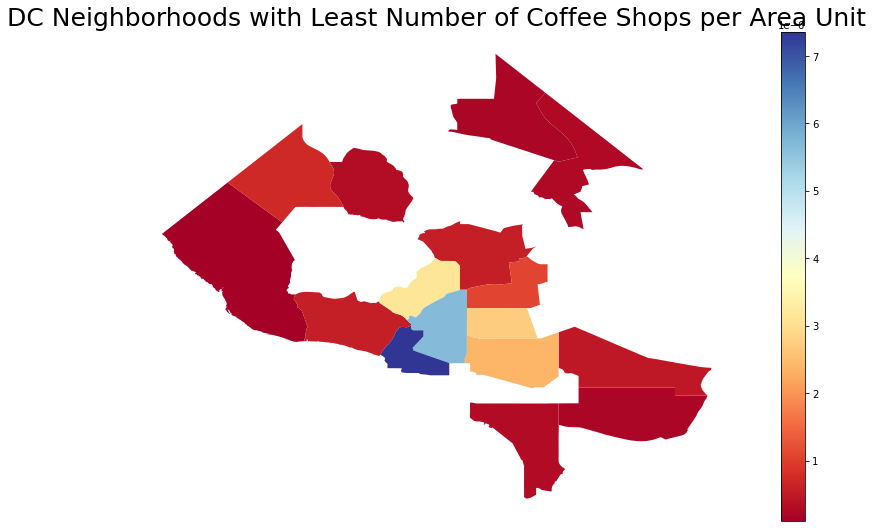

In [20]:
import matplotlib.pyplot as plt

ax = neighborhood_final.plot(column='shops_per_area_unit', cmap ='RdYlBu', figsize=(15,9), legend=True)

#remove axes
ax.set_axis_off()

#add title to the map
ax.set_title('DC Neighborhoods with Least Number of Coffee Shops per Area Unit', fontdict= 
            {'fontsize':25})

plt.show()

Here's a plot to display the five locations we recommend.

In [21]:
top_5_prospects = neighborhood_final.head()

import folium

def create_map(neighborhood_dataframe):
    zoom_lat = 38.918281 
    zoom_lon = -77.026432

    dc_map = folium.Map(location=[zoom_lat, zoom_lon], zoom_start=12)

    for lat, lng, neighborhoods, num_coffee_shops in zip(neighborhood_dataframe['center_lat'],
                                                        neighborhood_dataframe['center_lon'],
                                                        neighborhood_dataframe['nbh_names'],
                                                        neighborhood_dataframe['num_coffee_shops']):
        label = f'Neighborhood: {neighborhoods}\n\nCoffee Shops: {num_coffee_shops}'
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(dc_map)  

    return dc_map

create_map(top_5_prospects)

Last, we can measure the Pearson correlation between the number of coffee shops per area unit and the number of metro stops per area unit.

In [22]:
neighborhood_final[['shops_per_area_unit', 'metro_stops_per_area_unit']].corr(method='pearson')

,shops_per_area_unit,metro_stops_per_area_unit
shops_per_area_unit,1.000000,-0.344056
metro_stops_per_area_unit,-0.344056,1.000000


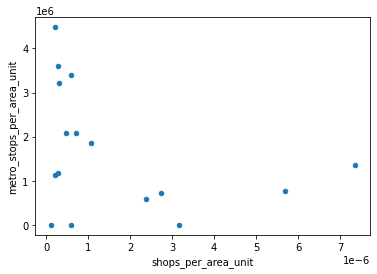

In [23]:
# need to convert from geodatafame to dataframe to plot
neighborhood_final_df = pd.DataFrame(neighborhood_final)

neighborhood_final_df.plot(kind='scatter', x='shops_per_area_unit', y='metro_stops_per_area_unit')

plt.show()

There is a slight inverse correlation between the two variables, meaning there are slightly less coffee shops in areas that have greater Metro access. There is an opportunity here: locations closer to Metro stops increase the number of potential customers both by virtue of their proximity to a stop and because a coffee shop closer to a Metro stop would have an advantage over other coffee shops, which are typically farther away from Metro stops.

## Conclusion

Above demonstrates my method and approach for determining the best location for building a coffee shop in DC. Because of the limitations of the free developer account, I cannot offer a recommendation here. Despite lacking full access to the developer API, the method and approach are sound and can offer insights into determining the proper location. To recap the method and approach I proposed and demonstrated here, I:

1. Acquired DC neighborhood geo data
2. Acquired DC metro stops geo data
3. Generated the number of metro stops per area unit of each neighborhood
4. Queried the Foursquare API for coffee shops in each neighborhood
5. Located which neighborhoods the coffee shops were in the vicinity of
6. Determined which neighborhoods had the highest number of cofee shops per area unit
7. Assessed the correlation between metro stops and coffee shops

If time permitted, I would enhance my analysis in order to provide a stronger recommendation by:

8. Calculating the number of checkins at all coffee shops in each neighborhood
9. Calculating the number of checkins divided by the number of coffee shops divided by area unit
10. The neighborhoods with the highest values in Step 9, would be the best locations
11. We can provide a final assessment of those locations by analyzing the locations based on whether there is a strong correlation between the number of metro stops in an area and factoring in the strengths and weaknesses of our data